# Hurricane Tweet Sentiment Analysis (Google Colab)

This notebook analyzes hurricane-related tweets and classifies them into 6 emotional categories:
- **Fear** - terror, being scared
- **Anger** - frustration, outrage  
- **Sadness** - grief, loss, despair
- **Joy** - relief, gratitude, hope
- **Anxiety** - worry, uncertainty
- **Humor** - jokes, sarcasm

## Setup Instructions

1. Get a API key from Groq: https://console.groq.com/keys
2. Upload your .csv file
3. Run all cells in order


In [ ]:
# Install Dependencies
%pip install groq pandas tqdm -q
print("Dependencies installed!")


Dependencies installed!


In [ ]:
# Set Up API Key
# Get key from: https://console.groq.com/keys

from google.colab import userdata
import os

# Use Colab Secrets
# Click the key icon in the left sidebar, add a secret named 'GROQ_API_KEY'
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    print("API key loaded from Colab Secrets!")
except:
    # Option 2: Paste your key directly here
    GROQ_API_KEY = ""  # <-- Paste your key here if not using secrets
    if GROQ_API_KEY:
        print("API key set manually!")
    else:
        print("Please set your GROQ_API_KEY above or add it to Colab Secrets ( icon on left)")

API key loaded from Colab Secrets!


In [ ]:
import os
import pandas as pd
import re

if os.path.exists('Hurricane_Harvey.csv'):
    print(" Hurricane_Harvey.csv found!")
else:
    from google.colab import files
    print("Please upload Hurricane_Harvey.csv:")
    uploaded = files.upload()


 Hurricane_Harvey.csv found!


In [ ]:
# Load and Clean Data

def clean_tweet(text):
    """Clean tweet text for analysis."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#(\w+)', r'\1', text)  # Remove hashtag symbols
    text = re.sub(r'^RT\s*:?\s*', '', text)  # Remove RT prefix
    text = ' '.join(text.split())  # Clean whitespace
    return text.strip()

# Load data
print("Loading data...")
df = pd.read_csv('Hurricane_Harvey.csv', encoding='latin-1')
print(f"Loaded {len(df):,} tweets")

# Clean tweets
df = df.dropna(subset=['Tweet'])
df['clean_text'] = df['Tweet'].apply(clean_tweet)
df = df[df['clean_text'].str.len() > 0].reset_index(drop=True)
print(f"After cleaning: {len(df):,} tweets")

# Preview
print("\n Sample tweets:")
for i, text in enumerate(df['clean_text'].head(3)):
    print(f"  {i+1}. {text[:80]}...")


Loading data...
Loaded 399,406 tweets
After cleaning: 398,873 tweets

 Sample tweets:
  1. If you do decide to drive in for ColdplayHouston be prepared to stay because the...
  2. As Hurricane Harvey is fast approaching, now is the time to do what you can to p...
  3. Is providing live HurricaneHarvey coverage for ? askingforafriend...


In [ ]:
# Configuration - adjustable settings!

# Number of tweets to analyze (start small to test!)
SAMPLE_SIZE = 100  # Set to None to analyze ALL tweets (will take hours)

# Whether to check if tweets are actually about hurricanes
CHECK_RELEVANCE = False  # Set to False to skip this step (2x faster)

# Model to use (all free on Groq!)
MODEL = "llama-3.1-8b-instant"  # Fast and good
# MODEL = "llama-3.3-70b-versatile"  # Higher quality, slower
# MODEL = "mixtral-8x7b-32768"  # Alternative

# Sentiment categories
CATEGORIES = ["fear", "anger", "sadness", "joy", "anxiety", "humor"]

print(f" Will analyze: {SAMPLE_SIZE if SAMPLE_SIZE else 'ALL'} tweets")
print(f" Relevance check: {'Yes' if CHECK_RELEVANCE else 'No'}")
print(f" Model: {MODEL}")


 Will analyze: 100 tweets
 Relevance check: No
 Model: llama-3.1-8b-instant


In [ ]:
# Initialize Sentiment Analyzer

from groq import Groq
import json
import time

client = Groq(api_key=GROQ_API_KEY)

def check_relevance(tweet):
    """Check if tweet is about actual hurricane weather event."""
    prompt = f"""Analyze this tweet and determine if it is discussing an actual hurricane weather event (not a sports team like the Miami Hurricanes, not a metaphor, not unrelated content).

Tweet: "{tweet}"

Respond with ONLY a JSON object: {{"is_relevant": true/false, "confidence": 0.0-1.0}}"""

    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=100
        )
        result = response.choices[0].message.content
        json_match = re.search(r'\{[^{}]*\}', result)
        if json_match:
            data = json.loads(json_match.group())
            return data.get('is_relevant', True), data.get('confidence', 0.5)
    except Exception as e:
        print(f"Error: {e}")
    return True, 0.5

def analyze_sentiment(tweet):
    """Classify tweet sentiment into one of 6 categories."""
    categories_str = ", ".join(CATEGORIES)

    prompt = f"""Analyze the emotional sentiment of this hurricane-related tweet. Classify it into exactly ONE of these categories: {categories_str}.

Definitions (choose the BEST fit):
- fear: IMMEDIATE danger or terror. Keywords: "terrified", "scared", "dangerous", "life-threatening", "pray for us"
- anger: frustration, outrage, blame. Keywords: "angry", "furious", "unacceptable", criticizing officials/response
- sadness: grief over LOSS that already happened. Keywords: "lost everything", "destroyed", "devastated", "heartbroken", "RIP"
- joy: relief, gratitude, hope, positive outcomes. Keywords: "thankful", "grateful", "safe", "survived", "thank god", "heroes"
- anxiety: uncertainty about the FUTURE, waiting. Keywords: "worried", "hoping", "not sure", "waiting to hear", "what if"
- humor: jokes, sarcasm, memes, making light of situation. Keywords: irony, exaggeration for comedic effect, dark humor

Choose FEAR over anxiety if there is IMMEDIATE danger being expressed.
Choose SADNESS over anxiety if discussing PAST losses.

Tweet: "{tweet}"

Respond with ONLY a JSON object: {{"sentiment": "category_name", "confidence": 0.0-1.0}}"""

    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.1,
            max_tokens=100
        )
        result = response.choices[0].message.content
        json_match = re.search(r'\{[^{}]*\}', result)
        if json_match:
            data = json.loads(json_match.group())
            sentiment = data.get('sentiment', 'unknown').lower()
            if sentiment in CATEGORIES:
                return sentiment, data.get('confidence', 0.5)
    except Exception as e:
        print(f"Error: {e}")
    return 'unknown', 0.0

print(" Sentiment analyzer ready!")

# Quick test
test_tweet = "I'm so scared, the hurricane is getting closer to our house"
sentiment, conf = analyze_sentiment(test_tweet)
print(f"\n Test: '{test_tweet}'")
print(f"   Result: {sentiment} ({conf:.0%} confidence)")


 Sentiment analyzer ready!

 Test: 'I'm so scared, the hurricane is getting closer to our house'
   Result: fear (100% confidence)


In [ ]:
# Run Analysis

from tqdm.notebook import tqdm

# Sample data
if SAMPLE_SIZE:
    analysis_df = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).reset_index(drop=True) #seed if you want same samples analyzed
else:
    analysis_df = df.copy()

#Time to process
print(f"Starting analysis of {len(analysis_df)} tweets...")
est_time = len(analysis_df) * (2 if CHECK_RELEVANCE else 1) * 0.3 / 60
#print(f"Estimated time: ~{est_time:.1f} minutes")

results = []

#progress bar
for idx, row in tqdm(analysis_df.iterrows(), total=len(analysis_df), desc="Analyzing"):
    tweet = row['clean_text']

    result = {
        'original_tweet': row['Tweet'],
        'clean_tweet': tweet,
        'is_relevant': True,
        'relevance_confidence': 1.0,
        'sentiment': None,
        'sentiment_confidence': None
    }

    # Check relevance if enabled
    if CHECK_RELEVANCE:
        is_rel, rel_conf = check_relevance(tweet)
        result['is_relevant'] = is_rel
        result['relevance_confidence'] = rel_conf

        if not is_rel:
            result['sentiment'] = 'not_applicable'
            result['sentiment_confidence'] = 0.0
            results.append(result)
            time.sleep(0.05)
            continue

    # Analyze sentiment
    sentiment, sent_conf = analyze_sentiment(tweet)
    result['sentiment'] = sentiment
    result['sentiment_confidence'] = sent_conf
    results.append(result)
    time.sleep(0.05)  # Small delay for rate limits

results_df = pd.DataFrame(results)
print(f"\n Analysis complete! Processed {len(results_df)} tweets.")

Starting analysis of 100 tweets...
Estimated time: ~0.5 minutes


Analyzing:   0%|          | 0/100 [00:00<?, ?it/s]


 Analysis complete! Processed 100 tweets.


In [ ]:
# Step 8: View Results Summary

print("ANALYSIS SUMMARY")


total = len(results_df)
relevant = results_df[results_df['is_relevant'] == True]

print(f"\nRelevance:")
print(f"  Total tweets analyzed: {total}")
print(f"  Hurricane-relevant: {len(relevant)} ({len(relevant)/total:.1%})")
print(f"  Not relevant: {total - len(relevant)}")

if len(relevant) > 0:
    print(f"\nSentiment Distribution (relevant tweets):")
    sentiment_counts = relevant['sentiment'].value_counts()
    for sentiment, count in sentiment_counts.items():
        pct = count / len(relevant) * 100
        bar = '█' * int(pct / 3)
        print(f"  {sentiment:12s}: {count:5d} ({pct:5.1f}%) {bar}")

ANALYSIS SUMMARY

Relevance:
  Total tweets analyzed: 100
  Hurricane-relevant: 100 (100.0%)
  Not relevant: 0

Sentiment Distribution (relevant tweets):
  anxiety     :    55 ( 55.0%) ██████████████████
  fear        :    18 ( 18.0%) ██████
  anger       :    12 ( 12.0%) ████
  joy         :     7 (  7.0%) ██
  humor       :     7 (  7.0%) ██
  sadness     :     1 (  1.0%) 


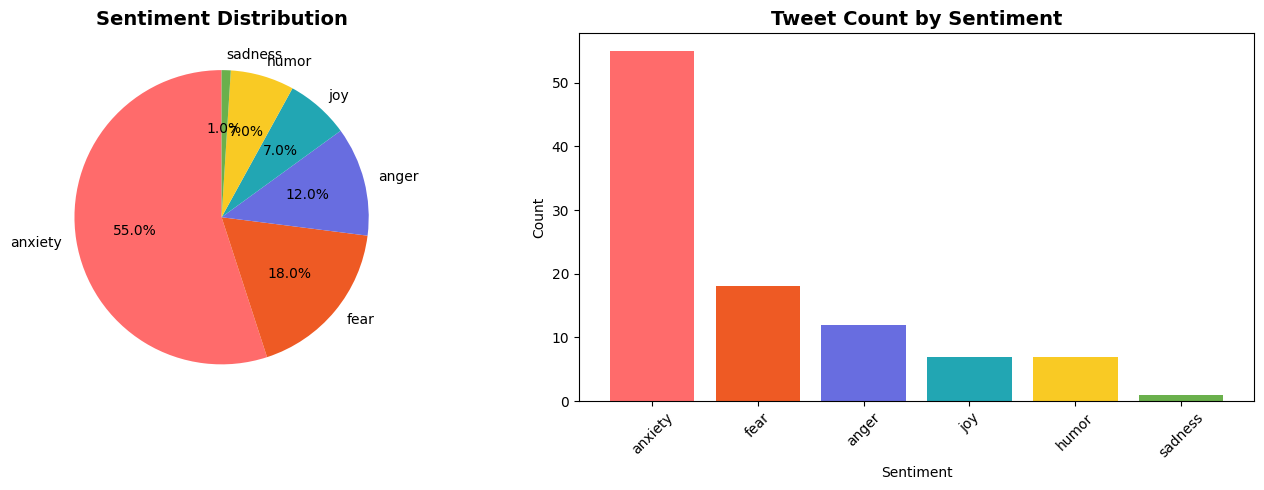

In [ ]:
import matplotlib.pyplot as plt

if len(relevant) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sentiment_counts = relevant['sentiment'].value_counts()
    colors = ['#ff6b6b', '#ee5a24', '#686de0', '#22a6b3', '#f9ca24', '#6ab04c']

    # Pie chart
    axes[0].pie(sentiment_counts.values, labels=sentiment_counts.index,
                autopct='%1.1f%%', colors=colors[:len(sentiment_counts)], startangle=90)
    axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')

    # Bar chart
    axes[1].bar(sentiment_counts.index, sentiment_counts.values, color=colors[:len(sentiment_counts)])
    axes[1].set_xlabel('Sentiment')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Tweet Count by Sentiment', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("No relevant tweets found to visualize.")

In [ ]:

print("SAMPLE TWEETS BY SENTIMENT")

for sentiment in CATEGORIES:
    subset = relevant[relevant['sentiment'] == sentiment]
    if len(subset) > 0:
        print(f"\n{sentiment.upper()} ({len(subset)} tweets):")
        for _, row in subset.head(5).iterrows():
            print(f"  • {row['original_tweet']}")  # Full original tweet with URLs, mentions, etc.
            print()



SAMPLE TWEETS BY SENTIMENT

FEAR (18 tweets):
  • #HurricaneHarvey https://twitter.com/WeatherFlowCHAS/status/901235310566289409 ?

  • Texas -Hurricane Harvey- scary. Spoke with Shirley Schwantz- they're ok at present. Kevin at Silverstone.

  • At least one dead, buildings destroyed as Hurricane Harvey drenches central Texas coast https://goo.gl/fb/MnguAr 

  • Wow wow
Alert: Hurricane Harvey upgraded to Category 4. Expected to make landfall tonight. Please exercise caution

  • Harvey bears down on Texas as Category 4 hurricane http://ift.tt/2ixxb0x 


ANGER (12 tweets):
  • How long before we hear @POTUS44 getting blamed for #HurricaneHarvey response? Many blamed him for #Katrina, don't forget.

  • Let's hope that POTUS will act like Hurricane Harvey annd PIVOT  back to his base and FIRE McMaster and get back to his base NO MORE WARS https://twitter.com/CraigRSawyer/status/901384866855395329 ?

  • Can anyone explain WHY anyone "likes" a tweet that tells about destruction and inj

In [ ]:
# Save and Download Results

output_file = 'analyzed_tweets.csv'
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Download the file
from google.colab import files
files.download(output_file)
print("Download started!")


Results saved to analyzed_tweets.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started!


## Done!

Your sentiment analysis is complete. The results CSV includes:
- `is_relevant`: Whether the tweet is about an actual hurricane (not sports team)
- `sentiment`: One of fear, anger, sadness, joy, anxiety, humor
- `confidence`: How confident the model is in its classification

### Tips for larger analyses:
- Groq has generous free limits (~30 requests/minute)
- For 400k tweets, consider running in batches
- Set `CHECK_RELEVANCE = False` to go 2x faster